Importando os dados

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


Saving dataHoldout.txt to dataHoldout.txt


Convertendo para Numpy

In [ ]:


dados = np.fromfile('dataHoldout.txt', dtype=np.float64)
dados = dados.reshape(-1, 3)
print(dados)

[[-0.29322959 -0.09065359  1.        ]
 [ 0.07988839  0.21101297  1.        ]
 [-0.07825563 -0.08083512  1.        ]
 ...
 [ 0.65980493  1.05876739  0.        ]
 [ 1.09867123  0.87404891  0.        ]
 [ 0.72930655  0.93224271  0.        ]]


Plotando Gráfico

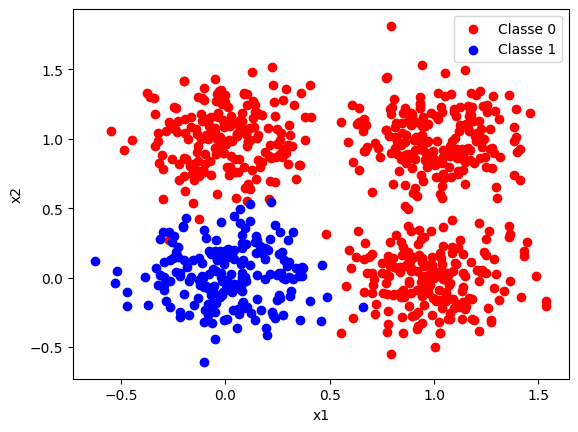

In [34]:
# Exemplo com classes
X = dados[:, :2]  # pega x1 e x2
y = dados[:, 2]   # pega yd

plt.scatter(X[y==0,0], X[y==0,1], c='red', label='Classe 0')
plt.scatter(X[y==1,0], X[y==1,1], c='blue', label='Classe 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


Dividir dataset

In [37]:
np.random.seed(4)

dados_aleatorios = np.random.permutation(dados)

#Dados de Treinamento 70%
dados_treinamento = dados_aleatorios[:int(0.7*len(dados_aleatorios))]

#Dados de Teste 30%
dados_teste = dados_aleatorios[int(0.7*len(dados_aleatorios)):]




560
240


Criar a classe do perceptron

In [57]:
class PerceptronRosenblat():
  def __init__(self):
    #Vies
    self.vies = 1
    #Ao iniciar a classe, os pesos são atribuidos de forma randomica
    self.pesos= np.array([np.random.uniform(-0.5,0.5),np.random.uniform(-0.5,0.5),np.random.uniform(-0.5,0.5)])
    self.taxa_de_aprendizado = 0.1

  def adicionar_vies(self, dados):
    for x in dados:
      dados_com_vies = np.array([np.insert(x, 0, self.vies) for x in dados])
    return dados_com_vies

  def funcao_ativacao_degrau(self, u):
    if u >= 0:
      return 1
    else:
      return 0

  def calcular_previsao(self,entradas):
    previsao = np.sum(entradas*self.pesos)

    return self.funcao_ativacao_degrau(float(previsao))

  def reajustar_pesos(self,entradas, saida, saida_desejada):
    novos_peso = self.pesos + self.taxa_de_aprendizado*(saida_desejada-saida)*entradas
    self.pesos = novos_peso

  def treinar(self, dados, epocas):
    dados = self.adicionar_vies(dados)

    for epoca in range(epocas):
      for x in dados:
        prever = self.calcular_previsao(x[:3])

        #Caso errar a previsão
        if(prever != x[3]):
          self.reajustar_pesos(x[:3], prever, x[3])
    return self.pesos

  def prever(self, dados):
    dados = self.adicionar_vies(dados)
    previsoes = []
    for x in dados:
      previsao = self.calcular_previsao(x[:3])
      previsoes.append(previsao)

    return previsao


In [60]:
#instanciar perceptron
perceptron = PerceptronRosenblat()

#Treinar
perceptron.treinar(dados_treinamento, 100)

#Testar
entradas = dados_teste[:, :2]
saidas = dados_teste[:, 2]
previsoes = perceptron.prever(entradas)

#acuracia
acertos = previsoes == saidas
acuracia = np.mean(acertos)
print("Acurácia:", acuracia)



Acurácia: 0.25
